In [1]:
# tutorials adapted for this notebook:
# https://github.com/ritvikmath/Time-Series-Analysis/blob/master/SARIMA%20Model.ipynb
# https://github.com/CoreyMSchafer/code_snippets/blob/master/Python/Pandas/10-Datetime-Timeseries/Pandas-Demo.ipynb
# https://github.com/gravesa333/Electricity_Load_Forecasting

# sharing link:
# https://github.com/amenewood/rds-dissertation/blob/main/EDF%20SARIMA%20final.ipynb

In [2]:
import numpy as np
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
register_matplotlib_converters()

from datetime import timedelta
from datetime import datetime
from time import time

import warnings

<h4>Part 1: Download & prepare raw data for time-series analysis

In [3]:
# download all available datasets and import as dataframes
url = 'https://data.nationalgrideso.com/backend/dataset/8f2fe0af-871c-488d-8bad-960426f24601/resource/bb44a1b5-75b1-4db2-8491-257f23385006/download/demanddata.csv'
r = requests.get(url)  
df2022 = pd.read_csv(io.StringIO(r.text))

url = 'https://data.nationalgrideso.com/backend/dataset/8f2fe0af-871c-488d-8bad-960426f24601/resource/18c69c42-f20d-46f0-84e9-e279045befc6/download/demanddata_2021.csv'
r = requests.get(url)  
df2021 = pd.read_csv(io.StringIO(r.text))

url = 'https://data.nationalgrideso.com/backend/dataset/8f2fe0af-871c-488d-8bad-960426f24601/resource/33ba6857-2a55-479f-9308-e5c4c53d4381/download/demanddata_2020.csv'
r = requests.get(url)  
df2020 = pd.read_csv(io.StringIO(r.text))

url = 'https://data.nationalgrideso.com/backend/dataset/8f2fe0af-871c-488d-8bad-960426f24601/resource/dd9de980-d724-415a-b344-d8ae11321432/download/demanddata_2019.csv'
r = requests.get(url)  
df2019 = pd.read_csv(io.StringIO(r.text))

url = 'https://data.nationalgrideso.com/backend/dataset/8f2fe0af-871c-488d-8bad-960426f24601/resource/fcb12133-0db0-4f27-a4a5-1669fd9f6d33/download/demanddata_2018.csv'
r = requests.get(url)  
df2018 = pd.read_csv(io.StringIO(r.text))

url = 'https://data.nationalgrideso.com/backend/dataset/8f2fe0af-871c-488d-8bad-960426f24601/resource/2f0f75b8-39c5-46ff-a914-ae38088ed022/download/demanddata_2017.csv'
r = requests.get(url)  
df2017 = pd.read_csv(io.StringIO(r.text))

url = 'https://data.nationalgrideso.com/backend/dataset/8f2fe0af-871c-488d-8bad-960426f24601/resource/3bb75a28-ab44-4a0b-9b1c-9be9715d3c44/download/demanddata_2016.csv'
r = requests.get(url)  
df2016 = pd.read_csv(io.StringIO(r.text))

In [4]:
# Combine datasets from 2022-2016
frames = [df2022, df2021, df2020, df2019, df2018, df2017, df2016]
result = pd.concat(frames)

In [5]:
result

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW
0,01-JAN-2022,1,21940,23275,20513,2412,6527,0,13080,0,450,-181,-4,586,320,384,-100,210.0,0.0
1,01-JAN-2022,2,22427,23489,21021,2554,6527,0,13080,0,173,-181,-4,583,320,403,-104,176.0,0.0
2,01-JAN-2022,3,21896,23672,20619,2696,6527,0,13080,0,799,-164,-4,567,320,440,-4,-205.0,0.0
3,01-JAN-2022,4,20693,23272,19615,2838,6527,0,13080,0,1516,-170,-4,444,320,387,-6,-283.0,0.0
4,01-JAN-2022,5,19481,23958,18545,2977,6527,0,13080,0,1490,-753,-4,-383,320,476,-561,-686.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17563,31-DEC-2016,44,29837,31233,27097,1735,4871,0,11503,0,5,-791,0,1000,159,59,0,NaN,NaN
17564,31-DEC-2016,45,28701,30304,26042,1742,4871,0,11503,0,5,-998,0,1000,221,116,0,NaN,NaN
17565,31-DEC-2016,46,28188,29800,25464,1750,4871,0,11503,0,11,-1001,0,999,206,213,0,NaN,NaN
17566,31-DEC-2016,47,27429,28126,24730,1694,4871,0,11503,0,20,-77,0,910,225,248,0,NaN,NaN


In [6]:
# keep ND column only--added copy() to suppress "copy of a slice" error
# TDS not used because it includes generation to "meet station load, pump storage pumping and interconnector exports"
# source: https://data.nationalgrideso.com/demand/historic-demand-data/r/historic_demand_data_2022
df = result[['SETTLEMENT_DATE','SETTLEMENT_PERIOD','ND']].copy()

# rename columns
df.columns = ['Date','Period','Demand_MW']

# recast date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y')

# make dataset a time series by using date as index
df.set_index('Date', inplace = True)

In [7]:
# resample to daily values, using the sum of demand (in MW) from all 48 settlement periods per day
df.resample('D').agg({'Demand_MW':'sum'})

,Demand_MW
Date,
2016-01-01,1409280
2016-01-02,1443410
2016-01-03,1480766
2016-01-04,1732697
2016-01-05,1780970
...,...
2022-08-17,1205772
2022-08-18,1191663
2022-08-19,1105925


In [8]:
# resample data to quarterly totals of demand 
df_qtr = df.resample('Q').agg({'Demand_MW':'sum'})

# convert quarterly totals to gigawatts (GW)
df_qtr['Demand_GW'] = df_qtr['Demand_MW']/1000

# delete column containing MW data
df_qtr.drop('Demand_MW', axis = 1, inplace=True)

<AxesSubplot:xlabel='Date'>

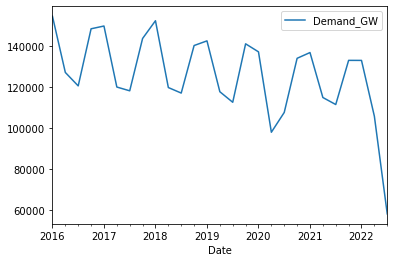

In [9]:
df_qtr.plot()

The above initial plot shows that the monthly totals for August is incomplete, so it needs to be excluded to prevent modelling errors later on.

In [10]:
# limit time series to exclude 2022 data (and use for comparing against forecasted 2022 data)
# code based on https://www.alpharithms.com/pandas-time-series-select-sub-set-range-463215/
train_df_qtr = df_qtr.loc['2016-03-31':'2021-12-31']

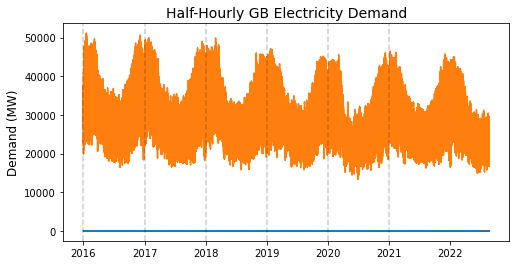

In [11]:
# plot original, unsampled dataset to include in report
plt.figure(figsize=(8,4))
plt.plot(df)
plt.title('Half-Hourly GB Electricity Demand', fontsize=14)
plt.ylabel('Demand (MW)', fontsize=12)
for year in range(2016, 2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [12]:
# Resampling to monthly totals and coverting to GW
df_mth = df.resample('M').agg({'Demand_MW':'sum'})
df_mth['Demand_GW'] = df_mth['Demand_MW']/1000
df_mth.drop('Demand_MW', axis = 1, inplace=True)

# limit time series to exclude 2022 data (and use for comparing against forecasted 2022 data)
# https://www.alpharithms.com/pandas-time-series-select-sub-set-range-463215/
train_df_mth = df_mth.loc['2016-03-31':'2021-12-31']

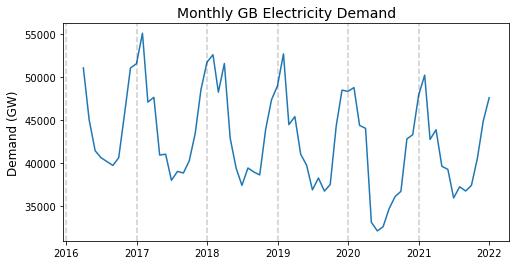

In [13]:
plt.figure(figsize=(8,4))
plt.plot(train_df_mth)
plt.title('Monthly GB Electricity Demand', fontsize=14)
plt.ylabel('Demand (GW)', fontsize=12)
for year in range(2016, 2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

The resampled monthly plot gives us a good idea of the seasonal patterns per year, with demand highest near the start of each year.  Let's resample the original data to a quarterly interval to visually compare the difference with the monthly version:

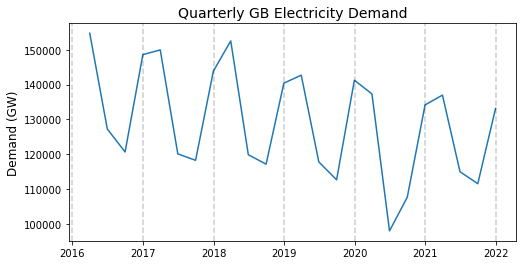

In [14]:
plt.figure(figsize=(8,4))
plt.plot(train_df_qtr)
plt.title('Quarterly GB Electricity Demand', fontsize=14)
plt.ylabel('Demand (GW)', fontsize=12)
for year in range(2016, 2023):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

While resampling the original dataset to aggregate the data to a quarterly frequency contains fewer datasets to train a model with (and quicker results with grid search), there is a loss of detail to the seasonal demand shape when compared to making a dataset resampled to monthly totals.

In [15]:
# set end of training data to the start of 2022 as January-July values will be predicted with the model
train_end = datetime(2022,1,1)

# set end of testing data to the start of August 2022, as August 2022 monthly data is incomplets
test_end = datetime(2022,8,1)

train_data = df_mth[:train_end]
test_data = df_mth['Demand_GW'][train_end + timedelta(days=1):test_end]


<h4>Part 2: Identify the Orders of the SARIMA Model Parameters Using Grid Search </h4> 

<p>The grid search method used to obtain the results of the top 3 SARIMA models returning the lowest MAPE for the training data (2016-2021) was executed as a standalone Python script outside this notebook.  The source code for this script is located at https://github.com/amenewood/rds-dissertation/blob/main/sarima-mth-mape-no-2022.py

```
[(2, 1, 2), (1, 1, 2, 12), 'ct'] 0.015259337503917654
[(2, 1, 2), (2, 1, 2, 12), 'ct'] 0.01678216394166141
[(2, 1, 0), (2, 1, 2, 12), 'c'] 0.017807423389270625
```

<h4>Part 3: Fit the SARIMA model</h4>
<p>Step 1: Define the training and testing sets using the resampled monthly data

Step 2: Fit the top  models returned from the grid search script:
<br>```(2, 1, 2), (1, 1, 2, 12)``` returned a MAPE of 15.2% based on the training data

In [16]:
# Model 1:

my_order = (2,1,2) # values for SARIMA (p,d,q)
my_seasonal_order = (1, 1, 2, 12) # values for SARIMA (P,D,Q,S)

# define model
model = SARIMAX(train_data, order = my_order, seasonal_order = my_seasonal_order)
model_fit = model.fit(disp=0) # disp=0 suppresses Kalman filter output

# calculate predicted values
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

/Users/doris/opt/anaconda3/envs/epf/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<h4>Part 3: Plot predicted values and compare against actual values</h4>

Text(0, 0.5, 'Demand (GW)')

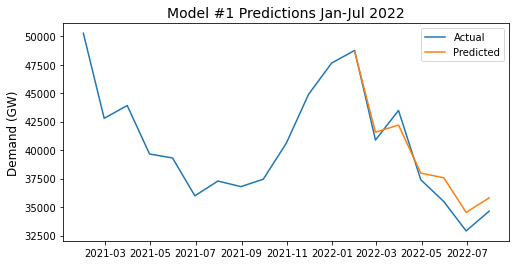

In [17]:
# plot predicted values vs. actual values for January-July 2022
plt.figure(figsize=(8,4))

plt.plot(df_mth.loc['2021-01-01':'2022-08-01'])
plt.plot(predictions.loc['2021-01-01':'2022-08-01'])

plt.legend(('Actual', 'Predicted'), fontsize=10)

plt.title('Model #1 Predictions Jan-Jul 2022', fontsize=14)
plt.ylabel('Demand (GW)', fontsize=12)

In [18]:
# calculate MAPE of the new predictions
print('Mean absolute percent error for Model 1:', round(np.mean(abs(residuals/test_data)),4))

Mean absolute percent error for Model 1: 0.0295


Repeat Part 2 for the 3rd SARIMA model from the grid search:
<br>```(2, 1, 2), (2, 1, 2, 12)``` returned a MAPE of 16.8% based on the training data

In [19]:
# Model 2

my_order = (2,1,2) # values for SARIMA (p,d,q)
my_seasonal_order = (2, 1, 2, 12) # values for SARIMA (P,D,Q,S)

# define model
model = SARIMAX(train_data, order = my_order, seasonal_order = my_seasonal_order)
model_fit = model.fit(disp=0) # disp=0 suppresses Kalman filter output

# calculate predicted values
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

/Users/doris/opt/anaconda3/envs/epf/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0, 0.5, 'Demand (GW)')

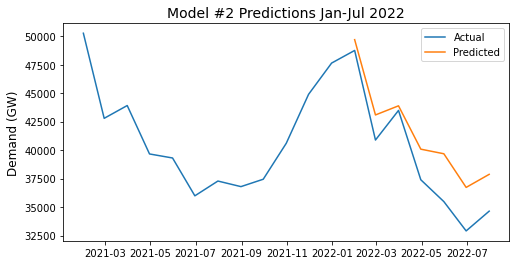

In [20]:
# plot predicted values vs. actual values for January-July 2022
plt.figure(figsize=(8,4))

plt.plot(df_mth.loc['2021-01-01':'2022-08-01'])
plt.plot(predictions.loc['2021-01-01':'2022-08-01'])

plt.legend(('Actual', 'Predicted'), fontsize=10)

plt.title('Model #2 Predictions Jan-Jul 2022', fontsize=14)
plt.ylabel('Demand (GW)', fontsize=12)

In [21]:
# calculate MAPE
print('Mean absolute percent error for Model 2:', round(np.mean(abs(residuals/test_data)),4))

Mean absolute percent error for Model 2: 0.0689


Repeat Part 3 for the 3rd SARIMA model from the grid search:
<br>```(2, 1, 0), (2, 1, 2, 12)``` returned a MAPE of 17.8% based on the training data

In [22]:
# Model 3

my_order = (2,1,2) # values for SARIMA (p,d,q)
my_seasonal_order = (2, 1, 2, 12) # values for SARIMA (P,D,Q,S)

# define model
model = SARIMAX(train_data, order = my_order, seasonal_order = my_seasonal_order)
model_fit = model.fit(disp=0) # disp=0 suppresses Kalman filter output

# calculate predicted values
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

/Users/doris/opt/anaconda3/envs/epf/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0, 0.5, 'Demand (GW)')

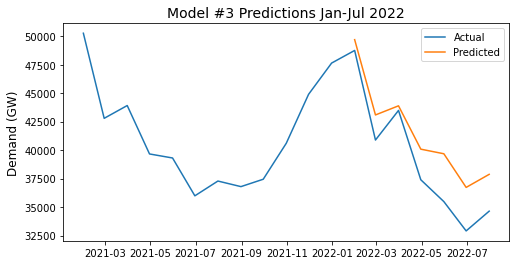

In [23]:
# plot predicted values vs. actual values for January-July 2022
plt.figure(figsize=(8,4))

plt.plot(df_mth.loc['2021-01-01':'2022-08-01'])
plt.plot(predictions.loc['2021-01-01':'2022-08-01'])

plt.legend(('Actual', 'Predicted'), fontsize=10)

plt.title('Model #3 Predictions Jan-Jul 2022', fontsize=14)
plt.ylabel('Demand (GW)', fontsize=12)

In [24]:
# calculate MAPE
print('Mean absolute percent error for Model 3:', round(np.mean(abs(residuals/test_data)),4))

Mean absolute percent error for Model 3: 0.0689


Repeat Part 3 for a SARIMA model outside the top 3 from the grid search:
<br>```(2, 1, 1), (0, 1, 1, 12)``` returned a MAPE of 40% based on the training data

In [25]:
# Non-top 3 model

my_order = (2,1,1) # values for SARIMA (p,d,q)
my_seasonal_order = (0, 1, 1, 12) # values for SARIMA (P,D,Q,S)

# define model
model = SARIMAX(train_data, order = my_order, seasonal_order = my_seasonal_order)
model_fit = model.fit(disp=0) # disp=0 suppresses Kalman filter output

# calculate predicted values
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

/Users/doris/opt/anaconda3/envs/epf/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Text(0, 0.5, 'Demand (GW)')

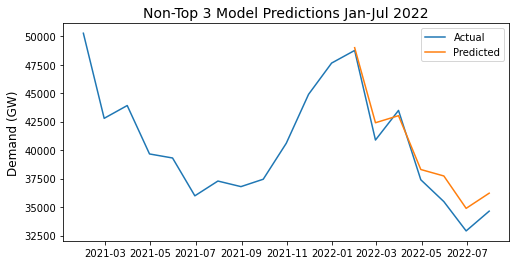

In [27]:
# plot predicted values vs. actual values for January-July 2022
plt.figure(figsize=(8,4))

plt.plot(df_mth.loc['2021-01-01':'2022-08-01'])
plt.plot(predictions.loc['2021-01-01':'2022-08-01'])

plt.legend(('Actual', 'Predicted'), fontsize=10)

plt.title('Non-Top 3 Model Predictions Jan-Jul 2022', fontsize=14)
plt.ylabel('Demand (GW)', fontsize=12)


In [28]:
# calculate MAPE
print('Mean absolute percent error for non-top 3 Model:', round(np.mean(abs(residuals/test_data)),4))

Mean absolute percent error for non-top 3 Model: 0.0351
